In [41]:
from data_fns import load_mnist
from estimator import RFClassifier, classical_weights, V1_inspired_weights, relu, parallelized_clf
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as la
import pickle

In [42]:
import dask
from dask.distributed import Client
client = Client(threads_per_worker=5, n_workers=5)
client

/home/bpandey/anaconda3/lib/python3.7/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


Client Scheduler: tcp://127.0.0.1:36767 Dashboard: http://127.0.0.1:34467/status,Cluster Workers: 5 Cores: 25 Memory: 135.06 GB


In [3]:
# load data
X_train, y_train, X_test, y_test = load_mnist('data/mnist')

In [4]:
n_features = sorted(set(np.logspace(0, 4, 100).astype('int')))

# weight params
t, l = 5, 3
kwargs = {'t': t, 'l': l}
weights_V1 = {'weight_fun': V1_inspired_weights, 'kwargs': kwargs}
weights_classical = {'weight_fun': classical_weights}

# params for classification
sgd = SGDClassifier(loss="squared_hinge", alpha=1, max_iter=200, tol=1e-5, shuffle=True, n_jobs=5,
                    learning_rate="optimal", early_stopping=True, validation_fraction=0.1, n_iter_no_change=20)
b = np.mean(la.norm(X_train)/ np.sqrt(X_train.shape[0]))

In [33]:
# %%time
# results = {}
# m = np.zeros_like(n_features, dtype='float')
# results['classical'] = {'avg_test_err': m.copy(), 'std_test_err': m.copy()}
# results['V1'] = {'avg_test_err': m.copy(), 'std_test_err': m.copy()}
# for i, n in enumerate(n_features):

#     # classical random features
#     params_classical = {'width': n, **weights_classical, 'bias': b, 'nonlinearity': relu, 'clf': sgd}
#     _, _, results['classical']['avg_test_err'][i], results['classical']['std_test_err'][i] = parallelized_clf(RFClassifier, 
#                                                                                                     params_classical, 
#                                                                                                     X_train, y_train, 
#                                                                                                     X_test, y_test, 
#                                                                                                     n_iters=5)
    
#     # haltere inspired
#     params_V1 = {'width': n, **weights_V1, 'bias': b, 'nonlinearity': relu, 'clf': sgd} 
#     _, _, results['V1']['avg_test_err'][i], results['V1']['std_test_err'][i] = parallelized_clf(RFClassifier, 
#                                                                                                 params_V1, 
#                                                                                                 X_train, y_train, 
#                                                                                                 X_test, y_test, 
#                                                                                                 n_iters=5)

#     print('Iter: %d/%d' % (i, len(n_features)))
    
with open('results/mnist_clf/mnist_clf_t=%0.2f_l=%0.2f.pickle' % (t, l), 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)
    

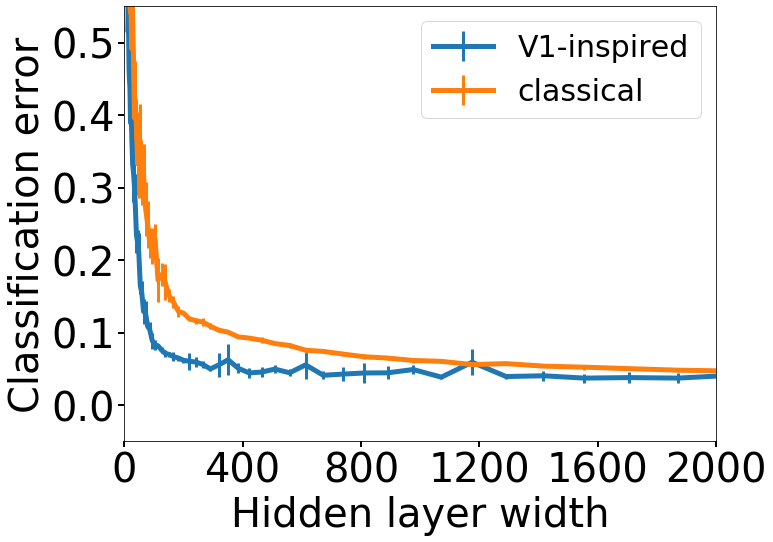

In [37]:
fig = plt.figure(figsize=(10.6, 8))
ax = fig.add_subplot(111)
ax.errorbar(n_features, results['V1']['avg_test_err'], yerr=results['V1']['std_test_err'], fmt='-', 
            label='V1-inspired',  markersize=4, lw=5, elinewidth=3)
ax.errorbar(n_features, results['classical']['avg_test_err'], yerr=results['classical']['std_test_err'], 
            fmt='-', label='classical', markersize=4, lw=5, elinewidth=3)
plt.xlabel('Hidden layer width', fontsize=40)
plt.ylabel('Classification error', fontsize=40)
plt.xticks(np.arange(0, 1020, 200))
plt.xlim([0, 2000])
plt.yticks(np.arange(0, 0.6, 0.1))
plt.ylim([-0.05, 0.55])
plt.xticks(np.arange(0, 2200, 400))
ax.tick_params(axis = 'both', which = 'major', labelsize = 40, width=2, length=6)

plt.legend(loc = 'upper right', fontsize=30)

mnist_clf_t=5.00_l=3.00.pickle


In [25]:
list(zip(n_features, results['V1']['avg_test_err']))

[(1, 0.8532399999999999),
 (2, 0.8292999999999999),
 (3, 0.76012),
 (4, 0.7700199999999999),
 (5, 0.72638),
 (6, 0.7303),
 (7, 0.6721799999999999),
 (8, 0.6511000000000001),
 (9, 0.6033999999999999),
 (10, 0.6028800000000001),
 (11, 0.58876),
 (12, 0.5714),
 (13, 0.51464),
 (14, 0.53314),
 (16, 0.46480000000000005),
 (17, 0.45202),
 (19, 0.43712),
 (21, 0.38938),
 (23, 0.40968),
 (25, 0.3742),
 (28, 0.33271999999999996),
 (31, 0.32161999999999996),
 (34, 0.30272),
 (37, 0.2774),
 (41, 0.23457999999999996),
 (45, 0.2242),
 (49, 0.20990000000000003),
 (54, 0.16434),
 (59, 0.15514),
 (65, 0.12932),
 (72, 0.12622000000000003),
 (79, 0.10880000000000001),
 (86, 0.10395999999999998),
 (95, 0.08837999999999999),
 (104, 0.08330000000000001),
 (114, 0.08170000000000002),
 (126, 0.07577999999999999),
 (138, 0.07138),
 (151, 0.06998),
 (166, 0.06699999999999998),
 (183, 0.06483999999999998),
 (200, 0.061760000000000016),
 (220, 0.06039999999999997),
 (242, 0.05933999999999999),
 (265, 0.056079999

### Few shot learning

In [54]:
train, train_labels, test, test_labels = load_mnist('data/mnist')
num_train = 50
X_train, _, y_train, _ = train_test_split(train, train_labels, train_size=num_train, stratify=train_labels, 
                                          random_state=42)
X_test, y_test = test.copy(), test_labels.copy()

In [55]:
n_features = sorted(set(np.logspace(0, 3, 50).astype('int')))

# weight params
t, l = 5, 3
kwargs = {'t': t, 'l': l}
weights_V1 = {'weight_fun': V1_inspired_weights, 'kwargs': kwargs}
weights_classical = {'weight_fun': classical_weights}

# params for classification
sgd = SGDClassifier(loss="squared_hinge", alpha=1, max_iter=200, tol=1e-5, shuffle=True, n_jobs=5,
                    learning_rate="optimal", early_stopping=True, validation_fraction=0.2, n_iter_no_change=20)
b = np.mean(la.norm(X_train)/ np.sqrt(X_train.shape[0]))

In [56]:
%%time
results = {}
m = np.zeros_like(n_features, dtype='float')
results['classical'] = {'avg_test_err': m.copy(), 'std_test_err': m.copy()}
results['V1'] = {'avg_test_err': m.copy(), 'std_test_err': m.copy()}
for i, n in enumerate(n_features):

    # classical random features
    params_classical = {'width': n, **weights_classical, 'bias': b, 'nonlinearity': relu, 'clf': sgd}
    _, _, results['classical']['avg_test_err'][i], results['classical']['std_test_err'][i] = parallelized_clf(RFClassifier, 
                                                                                                    params_classical, 
                                                                                                    X_train, y_train, 
                                                                                                    X_test, y_test, 
                                                                                                    n_iters=5)
    
    # haltere inspired
    params_V1 = {'width': n, **weights_V1, 'bias': b, 'nonlinearity': relu, 'clf': sgd} 
    _, _, results['V1']['avg_test_err'][i], results['V1']['std_test_err'][i] = parallelized_clf(RFClassifier, 
                                                                                                params_V1, 
                                                                                                X_train, y_train, 
                                                                                                X_test, y_test, 
                                                                                                n_iters=5)

    print('Iter: %d/%d' % (i, len(n_features)))
    
with open('results/mnist_clf/mnist_clf_t=%0.2f_l=%0.3f_few_shot.pickle' % (t, l), 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)
    

Iter: 0/42
Iter: 1/42
Iter: 2/42
Iter: 3/42
Iter: 4/42
Iter: 5/42
Iter: 6/42
Iter: 7/42
Iter: 8/42
Iter: 9/42
Iter: 10/42
Iter: 11/42
Iter: 12/42
Iter: 13/42
Iter: 14/42
Iter: 15/42
Iter: 16/42
Iter: 17/42
Iter: 18/42
Iter: 19/42
Iter: 20/42
Iter: 21/42
Iter: 22/42
Iter: 23/42
Iter: 24/42
Iter: 25/42
Iter: 26/42
Iter: 27/42
Iter: 28/42
Iter: 29/42
Iter: 30/42
Iter: 31/42
Iter: 32/42
Iter: 33/42
Iter: 34/42
Iter: 35/42
Iter: 36/42
Iter: 37/42
Iter: 38/42
Iter: 39/42
Iter: 40/42
Iter: 41/42


TypeError: only size-1 arrays can be converted to Python scalars

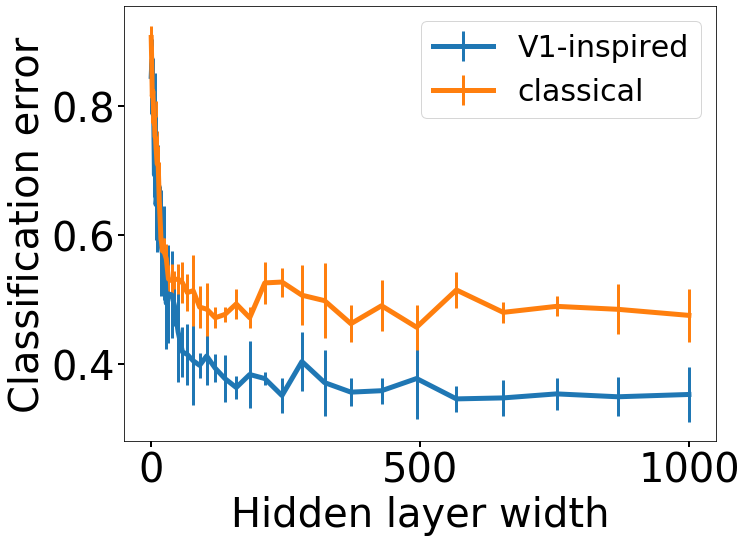

In [57]:
fig = plt.figure(figsize=(10.6, 8))
ax = fig.add_subplot(111)
ax.errorbar(n_features, results['V1']['avg_test_err'], yerr=results['V1']['std_test_err'], fmt='-', 
            label='V1-inspired',  markersize=4, lw=5, elinewidth=3)
ax.errorbar(n_features, results['classical']['avg_test_err'], yerr=results['classical']['std_test_err'], 
            fmt='-', label='classical', markersize=4, lw=5, elinewidth=3)
plt.xlabel('Hidden layer width', fontsize=40)
plt.ylabel('Classification error', fontsize=40)
# plt.xticks(np.arange(0, 1020, 200))
# plt.xlim([0, 1000])
# plt.yticks(np.arange(0, 0.6, 0.1))
# plt.ylim([-0.05, 0.55])
# plt.xticks(np.arange(0, 255, 50))
ax.tick_params(axis = 'both', which = 'major', labelsize = 40, width=2, length=6)

plt.legend(loc = 'upper right', fontsize=30)

In [58]:
results['V1']['avg_test_err']

array([0.84618, 0.86554, 0.87266, 0.7882 , 0.83684, 0.7627 , 0.69354,
       0.78224, 0.71292, 0.64746, 0.66528, 0.66514, 0.67478, 0.58742,
       0.57066, 0.57268, 0.49458, 0.50888, 0.50762, 0.49152, 0.4501 ,
       0.41914, 0.41514, 0.40534, 0.39822, 0.41272, 0.39372, 0.37766,
       0.36388, 0.38406, 0.37776, 0.35146, 0.40412, 0.37152, 0.35672,
       0.35892, 0.37782, 0.34624, 0.34776, 0.354  , 0.34952, 0.3531 ])